# SPACEc:Distance permutation analysis

In [1]:
import spacec as sp

#import standard packages
import os
import pandas as pd
import scanpy as sc

# silencing warnings
import warnings
warnings.filterwarnings('ignore')

/home/tim/miniforge3/envs/spacec/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/tim/miniforge3/envs/spacec/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/tim/miniforge3/envs/spacec/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/tim/miniforge3/envs/spacec/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/home/tim/miniforge3/envs/spacec/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_

In [2]:
# set plotting parameters
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [5]:
# Specify the path to the data
root_path = "/home/user/path/SPACEc/" # inset your own path

data_path = root_path + 'example_data/raw/' # where the data is stored

# where you want to store the output
output_dir = root_path + 'example_data/output/'
os.makedirs(output_dir, exist_ok=True)

In [16]:
# Load data
adata = sc.read(output_dir + "adata_nn_demo_annotated_cn.h5ad")
adata

AnnData object with n_obs × n_vars = 46789 × 59
    obs: 'DAPI', 'x', 'y', 'area', 'region_num', 'unique_region', 'condition', 'leiden_1', 'leiden_1_subcluster', 'cell_type_coarse', 'cell_type_coarse_subcluster', 'cell_type_coarse_f', 'cell_type_coarse_f_subcluster', 'cell_type_coarse_f_f', 'cell_type', 'CN_k20_n40', 'CN_k20_n30', 'CN_k20_n20', 'CN_k20_n25', 'CN_k20_n6', 'CN_k20_n6_annot'
    uns: 'CN_k20_n6_colors', 'Centroid_k20_n20', 'Centroid_k20_n25', 'Centroid_k20_n30', 'Centroid_k20_n40', 'Centroid_k20_n6', 'cell_type_coarse_f_colors', 'cell_type_colors', 'dendrogram_cell_type_coarse_f_subcluster', 'leiden', 'leiden_1_colors', 'neighbors', 'umap', 'unique_region_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'scaled'
    obsp: 'connectivities', 'distances'

## Identify potential interactions

In [ ]:
# compute the potential interactions
distance_pvals, results_dict = sp.tl.identify_interactions(
    adata = adata, # AnnData object
    cellid = "index", # column that contains the cell id (set index if the cell id is the index of the dataframe)
    x_pos = "x", # x coordinate column
    y_pos = "y", # y coordinate column
    cell_type = "cell_type", # column that contains the cell type information
    region = "unique_region", # column that contains the region information
    num_iterations=1000, # number of iterations for the permutation test
    num_cores=12,  # number of CPU threads to use
    min_observed = 10, # minimum number of observed interactions to consider a cell type pair
    comparison = 'condition', # column that contains the condition information we want to compare
    distance_threshold=20/0.5085) # distance threshold in px (20 µm)


In [8]:
# the results_dict contains the results of the permutation test as well as the observed and shuffled distances
results_dict.keys()

dict_keys(['distance_pvals', 'triangulation_distances_observed', 'triangulation_distances_iterated'])

In [6]:
# the distance_pvals contains the p-values for each cell type pair and is automatically added to the adata.uns
adata.uns['triDist']

,unique_region,celltype1_index,celltype1,celltype1_X,celltype1_Y,celltype2_index,celltype2,celltype2_X,celltype2_Y,distance,condition
0,reg002,3675,CD4+ T cell,612,1209,3752,Plasma cell,620,1220,13.601471,tonsillitis
1,reg002,15372,CD8+ T cell,1691,310,15416,Plasma cell,1697,296,15.231546,tonsillitis
2,reg002,6507,CD8+ T cell,897,651,6508,CD4+ T cell,897,672,21.000000,tonsillitis
3,reg002,7976,GCB,1033,1410,8070,GCB,1043,1425,18.027756,tonsillitis
4,reg002,22014,CD4+ T cell,2435,1409,22050,B cell,2444,1419,13.453624,tonsillitis
...,...,...,...,...,...,...,...,...,...,...,...
79446,reg001,49351,B cell,2835,847,49307,Epithelial cell,2841,871,24.738634,tonsil
79447,reg001,46044,Epithelial cell,2457,425,46027,Epithelial cell,2459,448,23.086793,tonsil
79448,reg001,47417,M2 Macrophage,2598,2274,47298,Mast cell,2609,2290,19.416488,tonsil
79449,reg001,43846,CD4+ T cell,2234,1393,43625,cDC1,2252,1390,18.248288,tonsil


In [22]:
# save adata
adata.write(output_dir + "adata_nn_demo_annotated_cn.h5ad")

## Filter for most significant results

In this example the results are filtered twice. First to remove rare cell types from the analysis because they are overrepresented when comparing distances, and then we filter on statistical significance as well as absolute log fold change.

In [19]:
distance_pvals_filt = sp.tl.remove_rare_cell_types(adata, 
                       distance_pvals, 
                       cell_type_column="cell_type", 
                       min_cell_type_percentage=1)

Cell types that belong to less than 1% of total cells:
['Mast cell', 'NK cell', 'Neutrophil']
Categories (15, object): ['B cell', 'CD4+ T cell', 'CD8+ T cell', 'DC', ..., 'Plasma cell', 'Treg', 'Vessel', 'cDC1']


In [20]:
# Identify significant cell-cell interactions
# dist_table_filt is a simplified table used for plotting
# dist_data_filt contains the filtered raw data with more information about the pairs
#  The function outputs two dataframes:  and dist_data_filt that contains all filtered interactions and  dist_table_filt that contains a table for all interactions that show a significant value in both tissues
dist_table_filt, dist_data_filt = sp.tl.filter_interactions(
    distance_pvals = distance_pvals_filt,
    pvalue = 0.05,
    logfold_group_abs = 0.1,
    comparison = 'condition')

print(dist_table_filt.shape)
dist_data_filt

(30, 2)


,celltype1,celltype2,condition,expected,expected_mean,keep_x,observed,observed_mean,keep_y,pvalue,logfold_group,interaction,logfold_group_abs,pairs
2,B cell,CD4+ T cell,tonsil,"[17.44611626424993, 17.240214223537937, 17.384...",17.508022,True,"[21.0, 14.7648230602334, 23.706539182259394, 2...",16.568973,True,2.649916e-54,-0.079532,B cell --> CD4+ T cell,0.079532,B cell_CD4+ T cell
3,B cell,CD4+ T cell,tonsillitis,"[17.991364990576724, 17.796405842536796, 17.37...",17.596348,True,"[22.255004511542957, 14.317821063276353, 27.29...",16.143926,True,1.783677e-80,-0.124285,B cell --> CD4+ T cell,0.124285,B cell_CD4+ T cell
4,B cell,CD8+ T cell,tonsil,"[17.578718052603264, 17.373822784572745, 17.52...",17.668738,True,"[14.142135623730951, 15.908466048591219, 13.60...",16.833803,True,1.343202e-32,-0.069838,B cell --> CD8+ T cell,0.069838,B cell_CD8+ T cell
5,B cell,CD8+ T cell,tonsillitis,"[17.220703294913235, 17.586321595513557, 17.69...",17.679001,True,"[13.92838827718412, 12.0, 22.47220505424423, 1...",16.493192,True,4.567463e-59,-0.100166,B cell --> CD8+ T cell,0.100166,B cell_CD8+ T cell
8,B cell,Epithelial cell,tonsil,"[17.112417871305603, 17.32405435992097, 17.480...",17.645577,True,"[25.495097567963924, 11.180339887498949, 32.0,...",17.582085,True,8.317085e-06,-0.005200,B cell --> Epithelial cell,0.005200,B cell_Epithelial cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,Vessel,Epithelial cell,tonsillitis,"[18.656136722237417, 17.23539386972536, 17.452...",17.697952,True,"[20.27019348662979, 25.553864678361276, 20.538...",19.468968,True,4.654472e-02,0.137594,Vessel --> Epithelial cell,0.137594,Vessel_Epithelial cell
400,Vessel,GCB,tonsil,"[17.123726173924652, 17.86949875671633, 17.259...",17.727516,True,"[23.219544457292887, 22.561028345356956, 31.57...",22.337618,True,1.868711e-05,0.333485,Vessel --> GCB,0.333485,Vessel_GCB
401,Vessel,GCB,tonsillitis,"[17.73771013605273, 18.023692483603742, 18.473...",17.674742,True,"[27.730849247724095, 18.679380239274902, 13.34...",19.167979,True,3.128661e-01,0.117009,Vessel --> GCB,0.117009,Vessel_GCB
428,cDC1,Epithelial cell,tonsil,"[18.463345515951513, 18.99715862104245, 17.564...",17.649416,True,"[19.235384061671343, 20.518284528683193, 21.93...",19.038398,True,6.141596e-03,0.109292,cDC1 --> Epithelial cell,0.109292,cDC1_Epithelial cell


## Visualization

condition                      tonsil  tonsillitis  abs_dist
pairs                                                       
CD8+ T cell_Epithelial cell -0.131908     0.124787  0.256695
Epithelial cell_CD8+ T cell -0.143348     0.104529  0.247876
Vessel_GCB                   0.333485     0.117009  0.216476
GCB_Vessel                   0.332078     0.131780  0.200298
B cell_Epithelial cell      -0.005200     0.194998  0.200199


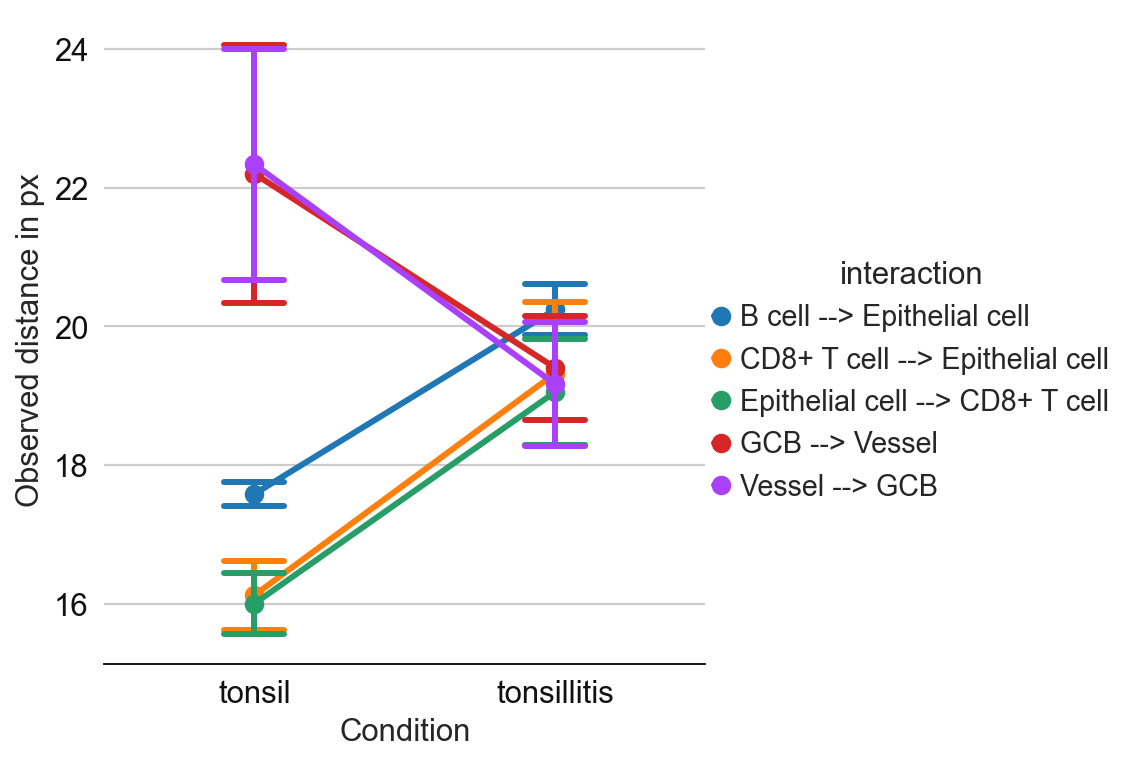

In [21]:
sp.pl.plot_top_n_distances(
    dist_table_filt,
    dist_data_filt,
    n=5,
    colors=None,
    dodge=False,
    savefig=False,
    output_fname="",
    output_dir="./",
    figsize=(5, 5),
    unit="px",
    errorbars=True,
)

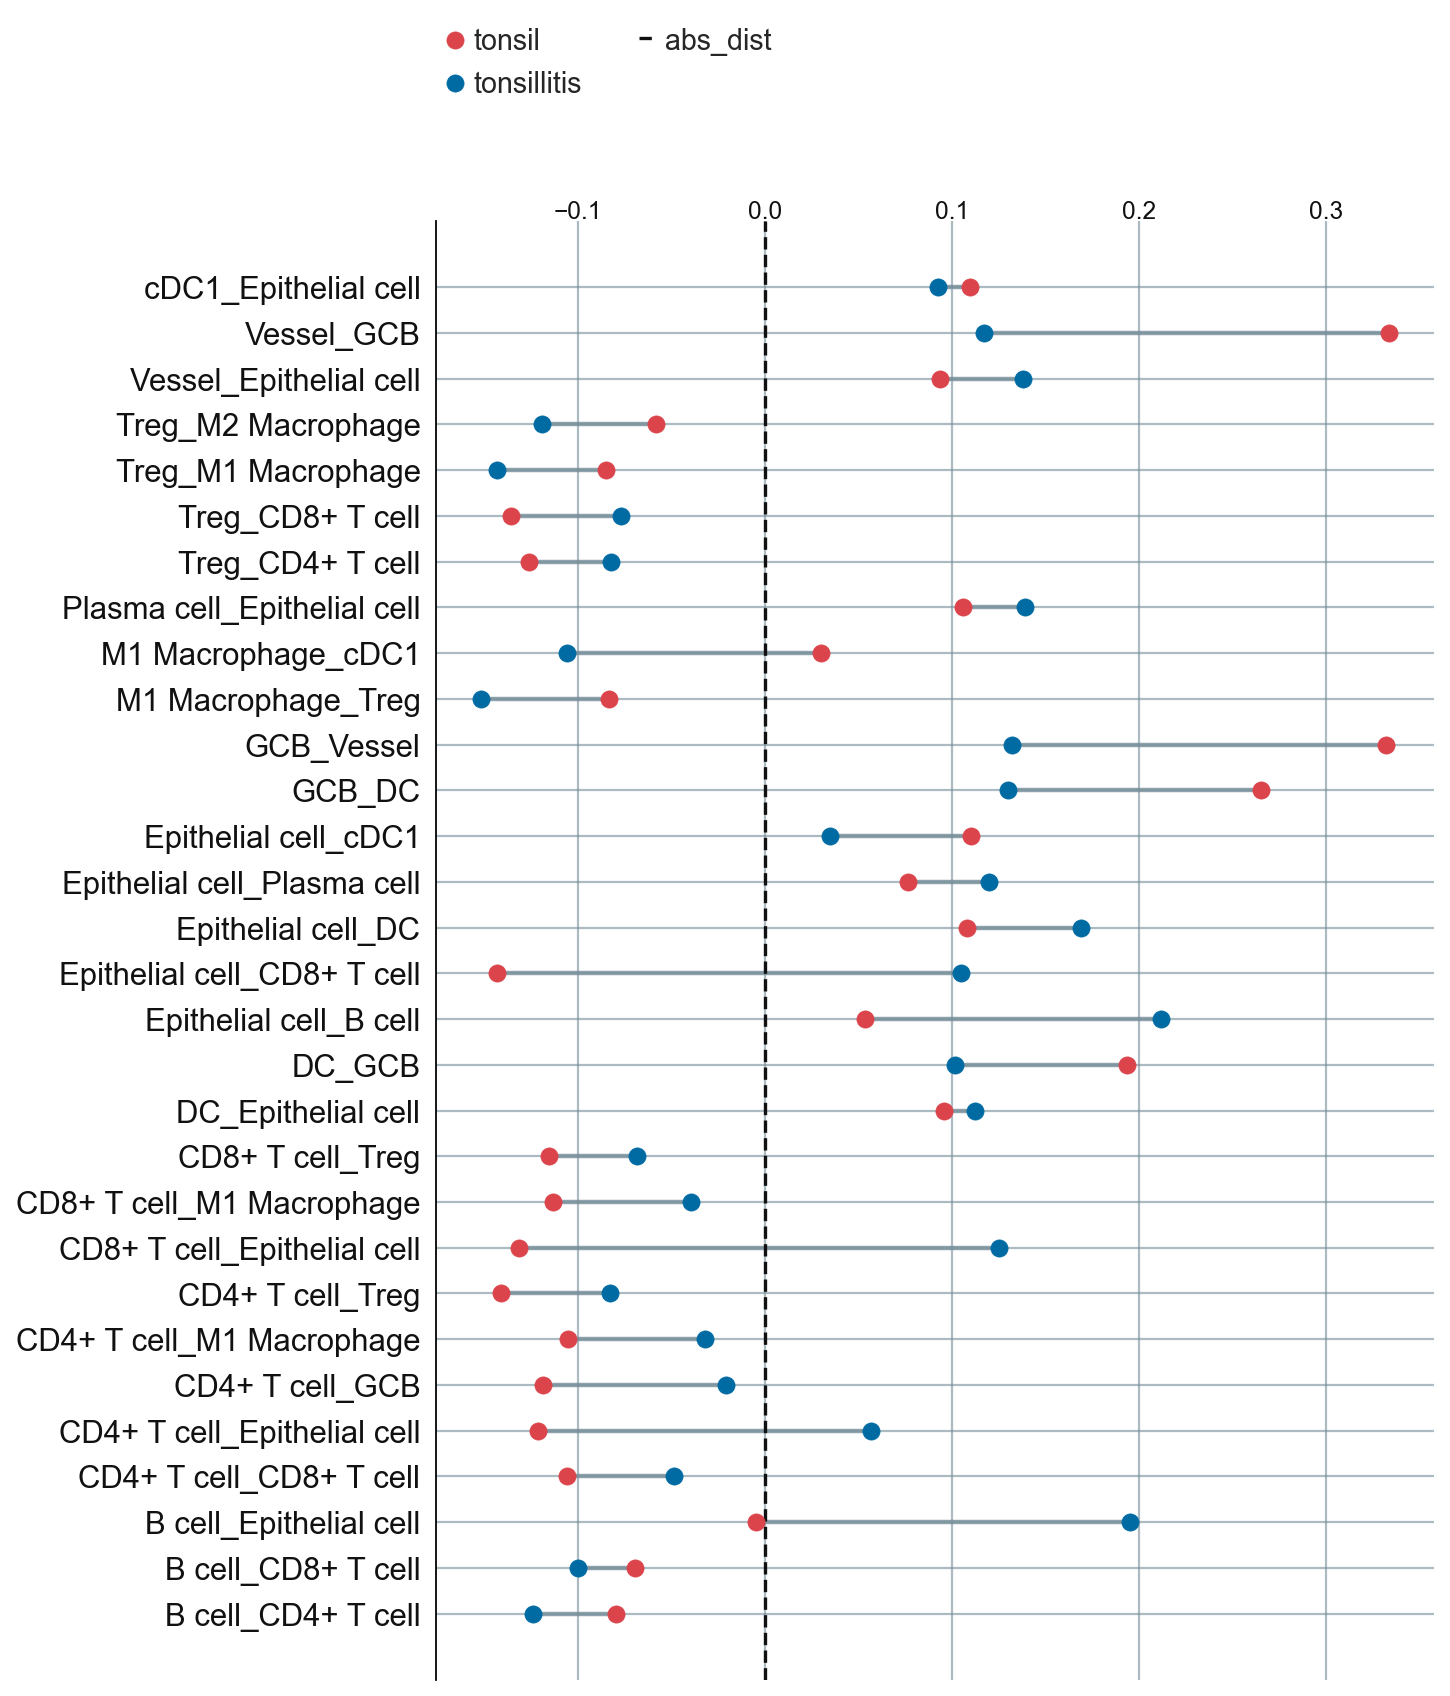

In [22]:
sp.pl.dumbbell(data = dist_table_filt, figsize=(8,12), colors = ['#DB444B', '#006BA2'])

(64, 13)


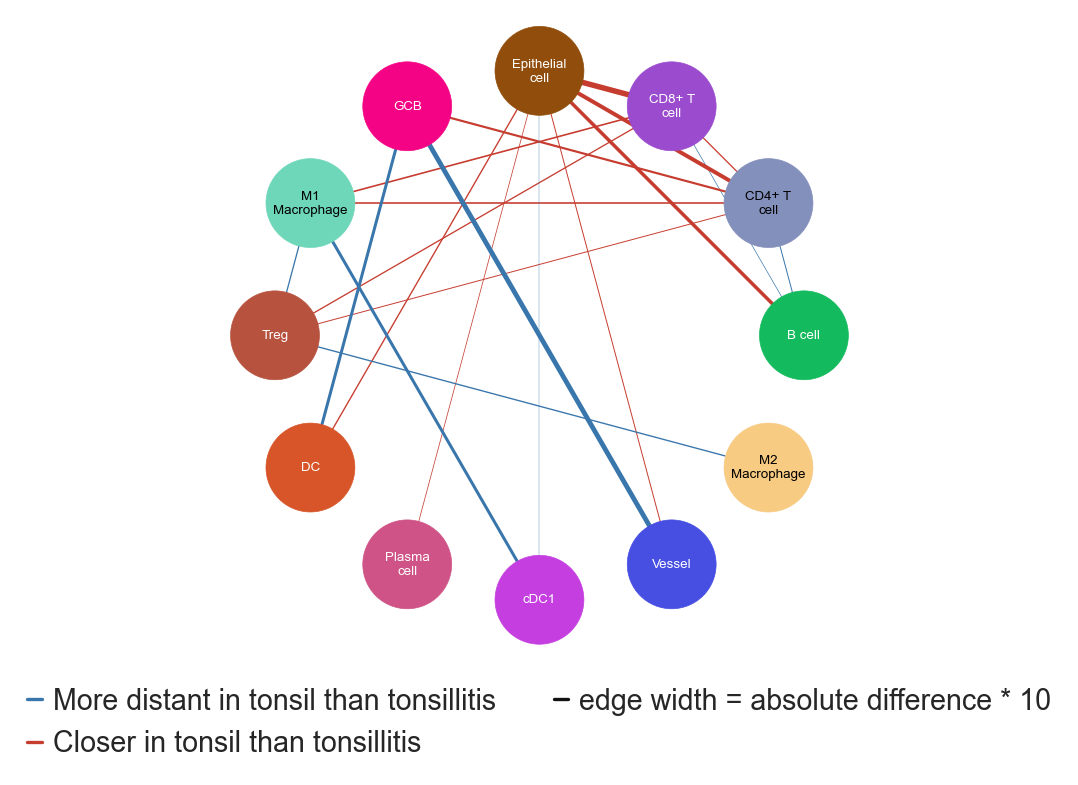

In [23]:
sp.pl.distance_graph(dist_table = dist_data_filt, # the (filtered) distance data table you want to plot 
                  distance_pvals = distance_pvals, # the full distance data table
                  condition_pair=['tonsil', 'tonsillitis'],
                  node_size=1600, font_size=6,
                  palette=None,
                  dpi = 600,
                  savefig=False,
                  output_fname="",
                  output_dir=output_dir,)